# 8.7. Redes densamente conectadas (DenseNet)

8.7. Densely Connected Networks (DenseNet)



O ResNet mudou significativamente a visão de como parametrizar as funções em redes profundas. O DenseNet (rede convolucional densa) é, até certo ponto, a extensão lógica disto ( Huang et al. , 2017 ) . O DenseNet é caracterizado tanto pelo padrão de conectividade onde cada camada se conecta a todas as camadas precedentes quanto pela operação de concatenação (em vez do operador de adição no ResNet) para preservar e reutilizar recursos de camadas anteriores.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 8.7.1. Do ResNet para o DenseNet

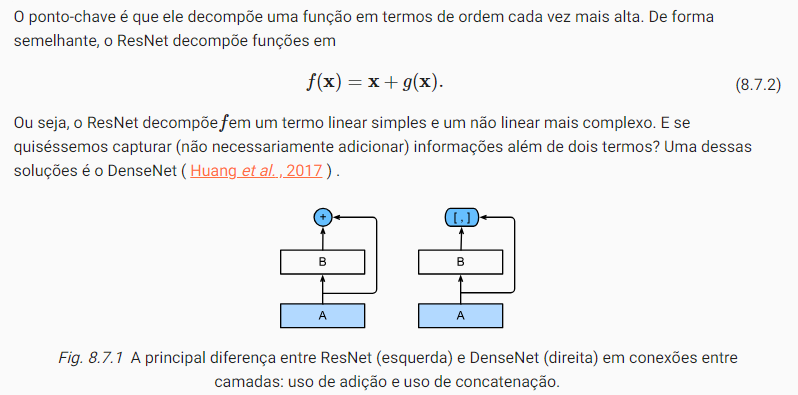

Saídas são concatenadas (denotadas por [ , ]).

A principal diferença entre ResNet e DenseNet é que no último caso as saídas são concatenadas.

Como resultado, realizamos um mapeamento de x aos seus valores após aplicar uma sequência cada vez mais complexa de funções:

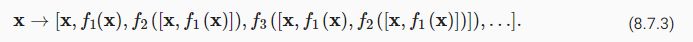

No final, todas essas funções são combinadas em MLP para reduzir o número de recursos novamente. Em termos de implementação, isso é bem simples: __em vez de adicionar termos, nós os concatenamos__. 

O nome DenseNet surge do fato de que o gráfico de dependência entre variáveis se torna bem denso. A camada final de tal cadeia é densamente conectada a todas as camadas anteriores. As conexões densas são mostradas na Fig. 8.7.2 .

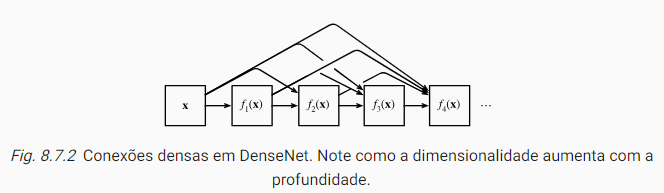

Os principais componentes que compõem uma DenseNet são blocos densos e camadas de transição:

- blocos densos: definem como as entradas e saídas são concatenadas;
- camadas de transição: controlam o número de canais para que não seja muito grande, uma vez que a expansão (8.7.3) pode ser bastante dimensional.

# 8.7.2. Blocos densos

O DenseNet usa a estrutura modificada de __“normalização em lote, ativação e convolução”__ do ResNet (veja o exercício 4 na Seção 8.6 ). Primeiro, implementamos essa estrutura de bloco de convolução.



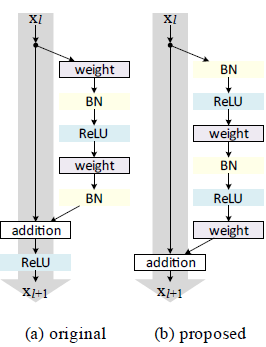

In [2]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))  
    # todas as convoluções utilizam o mesmo número de canais de saída, que é a dimensão do canal.


- Um bloco denso consiste em múltiplos blocos de convolução, __cada um usando o mesmo número de canais de saída__. 

- Na propagação para frente (foward), no entanto, concatenamos a entrada e a saída de cada bloco de convolução na dimensão do canal.

- A avaliação preguiçosa (Lazy) nos permite ajustar a dimensionalidade automaticamente.

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)                     # concatena input X e output Y.
        return X

- No exemplo a seguir, definimos uma DenseBlock instância com 2 blocos de convolução de 10 canais de saída: blk = DenseBlock(2, 10)

- Ao usar uma entrada com três canais, obteremos uma saída com 3 + 10 + 10 = 23 canais.

- O número de canais de bloco de convolução controla o crescimento no número de canais de saída em relação ao número de canais de entrada. Isso também é conhecido como taxa de crescimento.

In [4]:
blk = DenseBlock(2, 10)         # 2 blocos de convolução com 10 canais de saída. 
X = torch.randn(4, 3, 8, 8)     # entrada com 3 canais.
Y = blk(X)                      # saída Y com entrada X.
Y.shape

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

# 8.7.3. Camadas de transição

Como cada bloco denso aumentará o número de canais, adicionar muitos deles levará a um modelo excessivamente complexo. Uma camada de transição é usada para controlar a complexidade do modelo. Ela reduz o número de canais usando uma 1x1 convolução. Além disso, ele reduz pela metade a altura e a largura por meio de pooling médio com um passo de 2.

In [5]:
# “normalização em lote, ativação e convolução”
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),    # 1x1 convolução
        nn.AvgPool2d(kernel_size=2, stride=2))         # reduz pela metade a altura e a largura 

Aplique uma camada de transição com 10 canais à saída do bloco denso no exemplo anterior. Isso reduz o número de canais de saída para 10 e divide pela metade a altura e a largura.

In [6]:
blk = transition_block(10)
blk(Y).shape                       #  Y.shape:    torch.Size([4, 23, 8, 8])

torch.Size([4, 10, 4, 4])

# 8.7.4. Modelo DenseNet

Em seguida, construiremos um modelo DenseNet. O DenseNet usa primeiro a mesma camada convolucional única e camada de max-pooling como no ResNet.

In [9]:
class DenseNet(d2l.Classifier):          # identico ao ResNet
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- Então, similar aos quatro módulos compostos de blocos residuais que o ResNet usa, o DenseNet usa quatro blocos densos.

-  Assim como no ResNet, podemos definir o número de camadas convolucionais usadas em cada bloco denso. Aqui, definimos como 4, consistente com o modelo ResNet-18 na Seção 8.6 . Além disso, definimos o número de canais (ou seja, taxa de crescimento) para as camadas convolucionais no bloco denso como 32, então 128 canais serão adicionados a cada bloco denso.

- No ResNet, a altura e a largura são reduzidas entre cada módulo por um bloco residual com um passo de 2. 

- __Aqui, usamos a camada de transição para reduzir pela metade a altura e a largura e reduzir pela metade o número de canais.__ 

- Semelhante ao ResNet, uma camada de pooling global e uma camada totalmente conectada são conectadas no final para produzir a saída.

In [11]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))

    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

# 8.7.5. Treinamento

Como estamos usando uma rede mais profunda aqui, nesta seção, reduziremos a altura e a largura de entrada de 224 para 96 ​​para simplificar o cálculo.

In [ ]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

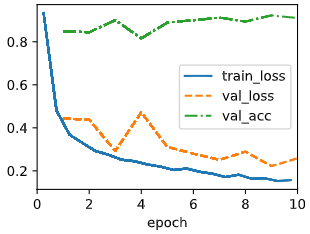

https://colab.research.google.com/drive/1UpYK-_659gUQS_HIFoiIFeh8HLykQUnv#scrollTo=UaMyXn9vmLkm

# 8.7.6. Resumo e Discussão


Os principais componentes que compõem o DenseNet são blocos densos e camadas de transição. Para o último, precisamos manter a dimensionalidade sob controle ao compor a rede adicionando camadas de transição que reduzem o número de canais novamente. Em termos de conexões entre camadas, em contraste com o ResNet, onde entradas e saídas são adicionadas juntas, o DenseNet concatena entradas e saídas na dimensão do canal. Embora essas operações de concatenação reutilizem recursos para atingir eficiência computacional, infelizmente elas levam a um alto consumo de memória da GPU. Como resultado, a aplicação do DenseNet pode exigir implementações mais eficientes em termos de memória que podem aumentar o tempo de treinamento ( Pleiss et al. , 2017 ).

# Código Agrupado

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# -----------------------------------------------------------------------------------------------------


# --------------------------------------------------------------------------------------------------------

def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))  
    # todas as convoluções utilizam o mesmo número de canais de saída, que é a dimensão do canal.

# --------------------------------------------------------------------------------------------------------

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)                     # concatena input X e output Y.
        return X

# --------------------------------------------------------------------------------------------------------

# “normalização em lote, ativação e convolução”
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),    # 1x1 convolução
        nn.AvgPool2d(kernel_size=2, stride=2))         # reduz pela metade a altura e a largura 

# --------------------------------------------------------------------------------------------------------

class DenseNet(d2l.Classifier):          # identico ao ResNet
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# --------------------------------------------------------------------------------------------------------

@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))

    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

# --------------------------------------------------------------------------------------------------------

model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

# --------------------------------------------------------------------------------------------------------





# 8.7.7. Exercícios

# Ex. 2 - Uma das vantagens mencionadas no artigo do DenseNet é que seus parâmetros de modelo são menores do que os do ResNet. Por que isso acontece?

# DenseNet:

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# --------------------------------------------------------------------------------------------------------

def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))  
    # todas as convoluções utilizam o mesmo número de canais de saída, que é a dimensão do canal.

# --------------------------------------------------------------------------------------------------------

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)                     # concatena input X e output Y.
        return X

# --------------------------------------------------------------------------------------------------------

# “normalização em lote, ativação e convolução”
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),    # 1x1 convolução
        nn.AvgPool2d(kernel_size=2, stride=2))         # reduz pela metade a altura e a largura 

# --------------------------------------------------------------------------------------------------------

class DenseNet(d2l.Classifier):          # identico ao ResNet
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# --------------------------------------------------------------------------------------------------------

@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))

    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

# --------------------------------------------------------------------------------------------------------

model = DenseNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
# trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
# trainer.fit(model, data)

# --------------------------------------------------------------------------------------------------------





C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = DenseNet(lr=0.01)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

{'conv': 75848, 'lr': 2490}

# ResNet18:

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# ----------------------------------------------------------------------------------------------

class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):                       # arquitetura definida
        Y = F.relu(self.bn1(self.conv1(X)))     #  funções aninhadas
        Y = self.bn2(self.conv2(Y))             #  funções aninhadas
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

# ----------------------------------------------------------------------------------------------

# Etapa Inicial (EI): b1
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# ----------------------------------------------------------------------------------------------

# Etapa Mediana (EM): block
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))   # com 1x1 convolução e saída reduzida pela metade.
        else:
            blk.append(Residual(num_channels))                                # sem 1x1 convolução e saída igual a entrada.
    return nn.Sequential(*blk)

# ----------------------------------------------------------------------------------------------

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()                      # inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.b1())                 # Etapa Inicial (EI): inicializado com o bloco inicial (ResNet) igual ao GoogLeNet.
    
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))  # Etapa Mediana (EM): blocos adicionados conforme a estrutura arch
    
    self.net.add_module('last', nn.Sequential(          # Etapa Final (EF)
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    
    self.net.apply(d2l.init_cnn)                        # Aplica a inicialização Xavier.

# ----------------------------------------------------------------------------------------------

class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

# ----------------------------------------------------------------------------------------------

model = ResNet18(lr=0.01)
# data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
# trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
# model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)



Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


In [5]:
# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = ResNet18(lr=0.01)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,928
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7           [-1, 64, 24, 24]          36,928
       BatchNorm2d-8           [-1, 64, 24, 24]             128
          Residual-9           [-1, 64, 24, 24]               0
           Conv2d-10           [-1, 64, 24, 24]          36,928
      BatchNorm2d-11           [-1, 64, 24, 24]             128
           Conv2d-12           [-1, 64, 24, 24]          36,928
      BatchNorm2d-13           [-1, 64, 24, 24]             128
         Residual-14           [-1, 64,

{'conv': 3200, 'lr': 5130}

The reason why DenseNet has smaller model parameters than ResNet is because DenseNet uses dense connections between layers, which means that each layer receives the feature maps of all preceding layers as input and passes its own feature maps to all subsequent layers. This way, the number of channels (filters) in each layer can be reduced, since the layer can reuse the features from previous layers. ResNet, on the other hand, uses residual connections, which means that each layer only receives the output of the previous layer and adds it to its own output. This requires more channels in each layer to learn new features, since the layer cannot access the features from earlier layers. According to the DenseNet paper¹, a 121-layer DenseNet has 7.98 million parameters, while a 152-layer ResNet has 60.19 million parameters. This is a significant difference in model size and complexity.

# Ex. 3 - Um problema pelo qual o DenseNet foi criticado é seu alto consumo de memória.

# 1. É realmente esse o caso? Tente mudar a forma de entrada para 224x224 para comparar empiricamente o consumo real de memória da GPU.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# --------------------------------------------------------------------------------------------------------

def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))  
    # todas as convoluções utilizam o mesmo número de canais de saída, que é a dimensão do canal.

# --------------------------------------------------------------------------------------------------------

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)                     # concatena input X e output Y.
        return X

# --------------------------------------------------------------------------------------------------------

# “normalização em lote, ativação e convolução”
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),    # 1x1 convolução
        nn.AvgPool2d(kernel_size=2, stride=2))         # reduz pela metade a altura e a largura 

# --------------------------------------------------------------------------------------------------------

class DenseNet(d2l.Classifier):          # identico ao ResNet
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# --------------------------------------------------------------------------------------------------------

@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))

    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

# --------------------------------------------------------------------------------------------------------

In [ ]:
# size=(96, 96):

data = d2l.FashionMNIST(batch_size=32, resize=(96, 96))
model = DenseNet(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
memory_stats = torch.cuda.memory_stats(device=device)
# Print peak memory usage and other memory statistics
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

In [ ]:
# size=(224, 224):

data = d2l.FashionMNIST(batch_size=32, resize=(224, 224))
model = DenseNet(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
memory_stats = torch.cuda.memory_stats(device=device)
# Print peak memory usage and other memory statistics
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

Tempos de execução:

- size=(96, 96):     6,6 min \
Peak memory usage: 343.55224609375 MB  \
Current memory usage: 22.10888671875 MB


- size=(224, 224):   29 min  \
Peak memory usage: 1336.16552734375 MB  \
Current memory usage: 212.91357421875 MB

https://colab.research.google.com/drive/1LkdrkRFpfRHKC7xyo8MwAxkP5I9wc1n8#scrollTo=7E0NV3wRo1_m

# Ex. 4 - Implementar as várias versões do DenseNet apresentadas na Tabela 1 do artigo do DenseNet ( Huang et al. , 2017 ) .

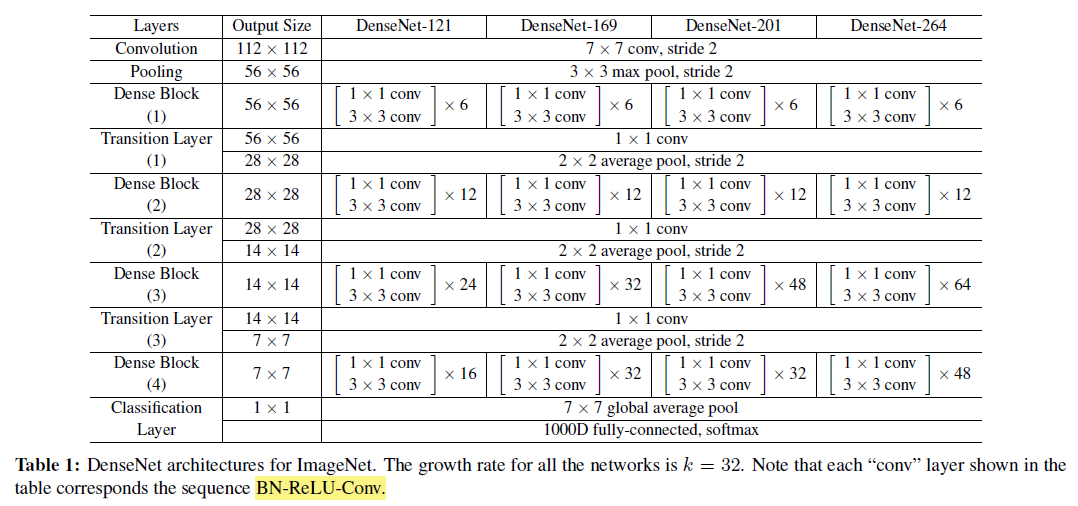

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# -----------------------------------------------------------------------------------------------------


# --------------------------------------------------------------------------------------------------------

def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))  
    # todas as convoluções utilizam o mesmo número de canais de saída, que é a dimensão do canal.

# --------------------------------------------------------------------------------------------------------

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)                     # concatena input X e output Y.
        return X

# --------------------------------------------------------------------------------------------------------

# “normalização em lote, ativação e convolução”
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),    # 1x1 convolução
        nn.AvgPool2d(kernel_size=2, stride=2))         # reduz pela metade a altura e a largura 

# --------------------------------------------------------------------------------------------------------

class DenseNet(d2l.Classifier):          # identico ao ResNet
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# --------------------------------------------------------------------------------------------------------

@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))

    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [8]:
# --------------------------------------------------------------------------------------------------------
# data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))

arch121 = (6,12,24,16)
arch169 = (6,12,32,32)
arch201 = (6,12,48,32)
arch264 = (6,12,64,48)
model = DenseNet(lr=0.01, arch=arch121)

# trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
# trainer.fit(model, data)

# --------------------------------------------------------------------------------------------------------

In [9]:
# arch=arch121
# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = DenseNet(lr=0.01, arch=arch121)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

{'conv': 692224, 'lr': 10250}

In [10]:
# arch=arch169
# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = DenseNet(lr=0.01, arch=arch169)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

{'conv': 987264, 'lr': 16650}

In [11]:
# arch=arch201
# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = DenseNet(lr=0.01, arch=arch201)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

{'conv': 1773952, 'lr': 19210}

In [12]:
# arch=arch264
# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(96,96)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = DenseNet(lr=0.01, arch=arch264)
X = torch.randn(1, 1, 96, 96)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (1, 96, 96))
params
# -----------------------------------------------------------------------------------------------------



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

{'conv': 2822784, 'lr': 26890}

In [14]:
# Resumo - Resultados Ex. 4

# arch=(4,4,4,4)    # original
# ================================================================
# Total params: 758,226
# Trainable params: 758,226
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.04
# Forward/backward pass size (MB): 14.29
# Params size (MB): 2.89
# Estimated Total Size (MB): 17.22
# ----------------------------------------------------------------
# {'conv': 75848, 'lr': 2490}

# ================================================================
# ================================================================

# # arch=arch121:    arch121 = (6,12,24,16)
# ================================================================
# Total params: 9,850,890
# Trainable params: 9,850,890
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.04
# Forward/backward pass size (MB): 38.02
# Params size (MB): 37.58
# Estimated Total Size (MB): 75.63
# ----------------------------------------------------------------
# {'conv': 692224, 'lr': 10250}

# ================================================================
# ================================================================

# # arch=arch169:    arch169 = (6,12,32,32)
# ================================================================
# Total params: 19,843,210
# Trainable params: 19,843,210
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.04
# Forward/backward pass size (MB): 46.85
# Params size (MB): 75.70
# Estimated Total Size (MB): 122.58
# ----------------------------------------------------------------
# {'conv': 987264, 'lr': 16650}

# ================================================================
# ================================================================

# # arch=arch201:    arch201 = (6,12,48,32)
# ================================================================
# Total params: 30,062,986
# Trainable params: 30,062,986
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.04
# Forward/backward pass size (MB): 62.04
# Params size (MB): 114.68
# Estimated Total Size (MB): 176.76
# ----------------------------------------------------------------
# {'conv': 1773952, 'lr': 19210}

# ================================================================
# ================================================================

# # arch=arch264:   arch264 = (6,12,64,48)
# ================================================================
# Total params: 54,137,482
# Trainable params: 54,137,482
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.04
# Forward/backward pass size (MB): 87.19
# Params size (MB): 206.52
# Estimated Total Size (MB): 293.75
# ----------------------------------------------------------------
# {'conv': 2822784, 'lr': 26890}

# Outras respostas:

https://pandalab.me/archives/densenet